<div align="center">

![alt text](https://upload.wikimedia.org/wikipedia/fr/e/e6/Logo_Polytechnique_Montr%C3%A9al_%28partenariat_Wikim%C3%A9dia%29.png)
_____

# INF8225
_____

## Rapport: TP 2

____

Elaboré par:



_____


HIVER 2020

_____
</div>


____
### Pseudocode
The algorithm have forward pass to predict the labels, then it calculates the derivatives and backpropagtes them backward, then it updates the weights and start over again by making another forward pass and so on ..

We define the terms :


*   for each layer, **node_in[ $l$ ]** is the representation of **$a^{(l)}$**
*   for each layer, **node_a[ $l$ ]** is the representation of **$h^{(l)}$** where $h$ is the activation function of the layer $l$
*   for each layer, **node_delta[ $l$ ]** is the representation of **$\Delta^{(l)}$**

```python
# neural network with L hidden layers
for epoch = 1 to N_epochs do:
	for each example do:
		# forward pass
		node_a[0] <- x_bias # the input example x appended with 1
		for l = 2 to L do:
			node_in[l] <- node_a[l - 1] @ θ.T # the operator @ is the matrix product
			node_a[l] <- g(node_in[l]) # g is the activation function of the layer l, 
            # g = relu for l<L and g = softmax of l=L
		
        # backpropagation
        node_delta[L] <- dg(node_in[L]) # dg is the derivative of the corresponding activation function g
		for l = L-1 to 1 do:
          node_delta[l] <- dg(node_in[l]) * (node_delta[l+1] @ W )   # dg is the derivative of the 
          # corresponding activation function g, W is the weight matrix
          # update parameters
          Teta[l+1] <- Teta[l+1] + lr * node_delta[l+1] * node_a[l]


```

## 1. b) Numpy Implementation

Nb of hidden layers = 3
Shape of layer # 0
(300, 785)
Shape of layer # 1
(300, 301)
Shape of layer # 2
(300, 301)
Shape of layer # 3
(10, 301)
__________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch : 1 / 20
54000/54000 [==============================] 100.0% - loss: 2.2950 - acc: 0.1544 - val_loss: 2.2951 - val_acc: 0.1512
Epoch : 2 / 20
54000/54000 [==============================] 100.0% - loss: 0.8376 - acc: 0.7037 - val_loss: 0.8306 - val_acc: 0.7057
Epoch : 3 / 20
54000/54000 [==============================] 100.0% - loss: 0.4435 - acc: 0.8667 - val_loss: 0.4587 - val_acc: 0.8587
Epoch : 4 / 20
54000/54000 [==============================] 100.0% - loss: 0.3809 - acc: 0.8886 - val_loss: 0.3946 - val_acc: 0.8848
Epoch : 5 / 20
54000/54000 [==============================] 100.0% - loss: 0.3236 - acc: 0.9068 - val_loss: 0.3417 - val_acc: 0.9020
Epoch : 6 / 20
54000/54000 [==============================] 100.0% - loss: 0.2925 - acc: 0.9

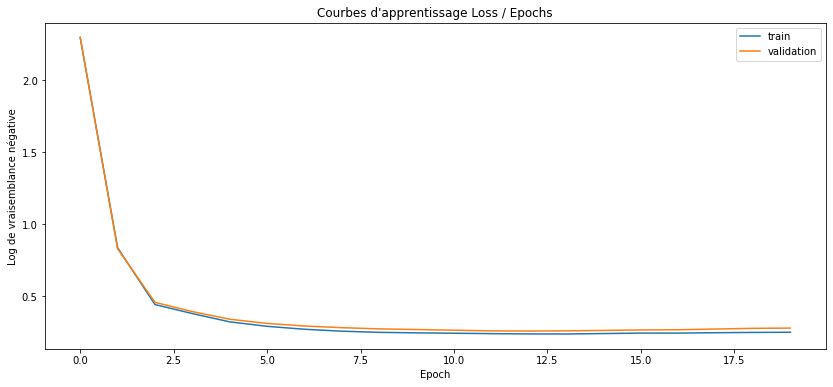

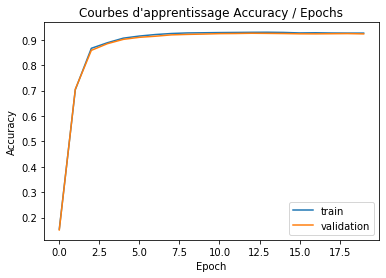

In [0]:
import time
import numpy as np
import sys
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def one_hot(y, K):
    y_one_hot = np.zeros((y.shape[0], K))  # we have K classes, the general form is len(np.unique(y)
    y_one_hot[np.arange(y.shape[0]), y] = 1  # one hot target or shape NxK
    return y_one_hot


def softmax(x):
    # this condition is for debugging purposes,
    # so we could detect exploding gradients
    if (np.isnan(x).any()):
        print('There is nan in softmax')
    expZ = np.exp(x - np.amax(x, axis=1, keepdims=True))
    return np.divide(expZ, np.sum(expZ, axis=1, keepdims=True))


def softmax_backward(y, y_pred):
    return (y - y_pred)


def relu(x):
    # this test condition is for debugging purposes,
    # so we could detect exploding gradients
    if (np.isnan(x).any()):
        print('There is nan in relu')
    return np.maximum(x, 0)


def relu_backward(X):
    x = np.copy(X)
    x[x < 0] = 0.0
    x[x >= 0] = 1.0
    # we do not use the diagonal form of the matrix but we use the vector instead,
    # then we do an elementwise product later
    return x


def get_loss(y, y_pred):
    eps = 1.0e-10
    y_pred = np.clip(y_pred, eps, 1 - eps)  # to prevent dividing by zero
    return - np.sum(y * np.log(y_pred)) / len(y) #
    # computing the average helps normalize curves to present them at the same scale when
    # the sizes of the train and validation set are not the same


def get_accuracy(y_pred, y):
    return np.sum(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)) / len(y)


class NeuralNetwork:
    def __init__(self,
                 no_of_in_nodes,
                 no_of_out_nodes,
                 no_of_hidden_nodes,
                 no_of_hidden_layers):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.no_of_hidden_layers = no_of_hidden_layers
        self.Teta = self.create_weight_matrices()

    # generating matrix Teta of weights = [ W  b ]
    def create_weight_matrices(self):
        Teta = []
        print("Nb of hidden layers = " + str(self.no_of_hidden_layers))
        for i in range(0, self.no_of_hidden_layers + 1):
            if i == 0:
                input_nodes = self.no_of_in_nodes
                output_nodes = self.no_of_hidden_nodes
            elif i == self.no_of_hidden_layers:
                input_nodes = self.no_of_hidden_nodes
                output_nodes = self.no_of_out_nodes
            else:
                input_nodes = self.no_of_hidden_nodes
                output_nodes = self.no_of_hidden_nodes
            print("Shape of layer # " + str(i))
            Teta_layer = np.random.normal(0, 0.01, 
                                          (output_nodes, input_nodes + 1))  # we add +1 to take b into consideration
            print(Teta_layer.shape)
            Teta.append(Teta_layer)
        return Teta  # list of np arrays

    # an optimised version of predict function
    def predict(self, X):
        # feedforward for all the examples and predict the output
        L = self.no_of_hidden_layers
        # forward pass for each example
        node_a_prev = np.copy(X)  # item j from the input vector of the example
        for l in range(1, L + 2):
            node_in = np.dot(node_a_prev, self.Teta[l - 1].T)  # in_i <- sum_j{W_j_i * a_j}
            if l < L + 1:
                # the hidden layers
                node_a_cur = relu(node_in)  # relu
                node_a_cur = np.concatenate((node_a_cur, np.ones((node_a_cur.shape[0], 1))), axis=1)  # add the bias b
            else:
                # the output layer
                node_a_cur = softmax(node_in)
            node_a_prev = np.copy(node_a_cur)
        return node_a_cur

    def progress(self, i, n):
        # just a fancy progress bar:
        sys.stdout.write('\r')
        sys.stdout.write("%5s/%5s [%-30s] %.1f%%" % (i, n, '=' * int(i * 30 / n), (100 / n) * i))
        sys.stdout.flush()

    def train(self, X_train, y_train, X_validation, y_validation, X_test, y_test, lr, nb_epochs, minibatch_size):
        # neural network with L hidden layers
        print('_' * 50)
        print('Train on %d samples, validate on %d samples' % (len(X_train), len(X_validation)))
        L = self.no_of_hidden_layers

        best_teta = None
        best_accuracy = 0
        losses_train = []
        losses_val = []
        accuracies_train = []
        accuracies_val = []

        for epoch in range(nb_epochs):
            loss = 0
            accuracy = 0
            print("Epoch : " + str(epoch + 1) + " / " + str(nb_epochs))

            for i in range(0, X_train.shape[0], minibatch_size):
                X_train_mini = X_train[i:i + minibatch_size] if (i + minibatch_size < X_train.shape[0]) \
                    else X_train[i:X_train.shape[0]]
                y_train_mini = y_train[i:i + minibatch_size] if (i + minibatch_size < X_train.shape[0]) \
                    else y_train[i:X_train.shape[0]]

                self.progress(min(i + minibatch_size, len(X_train)), len(X_train))
                # forward pass for each example
                # for each layer node_in is the list of nodes where node_in = W x + b
                node_in = [None] * (L + 2)
                # for each layer node_a is the list of nodes
                # where node_a = f(node_in), f is the activation function
                node_a = [None] * (L + 2)
                # for each layer node_delta is the list of nodes
                # where node_delta = f'(node_in), f' is the derivative of activation function
                node_delta = [None] * (L + 2)
                node_a[0] = X_train_mini  # item j from the input vector of the example
                for l in range(1, L + 2):
                    TetaT = np.fastCopyAndTranspose(self.Teta[l - 1])
                    node_in[l] = node_a[l - 1] @ TetaT  # in_i <- sum_j{Teta_j_i * a_j}

                    if l < L + 1:
                        # the hidden layers
                        node_a[l] = relu(node_in[l])  # relu
                        node_a[l] = np.concatenate((node_a[l], np.ones((node_a[l].shape[0], 1))),
                                                   axis=1)  # add the bias b to use it in the next layer
                    else:
                        # the output layer
                        node_a[l] = softmax(node_in[l])

                # backpropagation
                y = y_train_mini
                node_delta[L + 1] = softmax_backward(y, node_a[L + 1])
                for l in range(L, 0, -1):
                    node_delta[l] = relu_backward(node_a[l][:, :-1]) * (
                    (node_delta[l + 1] @ self.Teta[l][:, :-1]))  # W.T @ node_delta[l + 1]

                # update parameters
                for l in range(0, L + 1):
                    self.Teta[l] = self.Teta[l] + lr * (node_delta[l + 1].T @ node_a[
                        l])  # * 1 / len(node_a[l]) #(node_delta[l + 1].T @ node_a[l])
                    # self.Teta[l] = np.clip(self.Teta[l], -1000.0, 1000.0)

            # compute the loss on the train set
            y_train_pred = self.predict(X_train)
            loss = get_loss(y_train, y_train_pred)
            losses_train.append(loss)

            # compute the loss on the validation set
            y_validation_pred = self.predict(X_validation)
            loss_val = get_loss(y_validation, y_validation_pred)
            losses_val.append(loss_val)

            # compute the accuracy on the training set
            accuracy = get_accuracy(y_train_pred, y_train)
            accuracies_train.append(accuracy)

            # compute the accuracy on the validation set
            accuracy_val = get_accuracy(y_validation_pred, y_validation)
            accuracies_val.append(accuracy_val)

            print(' - loss: %.4f - acc: %.4f - val_loss: %.4f - val_acc: %.4f' % (loss, accuracy, loss_val, accuracy_val))

            if accuracy_val > best_accuracy:
                # select the best parameters based on the validation accuracy
                best_accuracy = accuracy_val
                best_teta = self.Teta

        # set Teta to the best matrix weights to use it to test the model on unseen data
        self.Teta = best_teta
        y_test_pred = self.predict(X_test)
        # compute the accuracy on the test set
        accuracy_on_unseen_data = get_accuracy(y_test_pred, y_test)
        print("Best Accuracy on validation data: %.4f" % (best_accuracy))
        print("Accuracy on test data: %.4f" % (accuracy_on_unseen_data))
        return losses_train, losses_val, accuracies_train, accuracies_val, best_teta, best_accuracy


def run():
    ((X_train, y_train), (X_test, y_test)) = mnist.load_data()

    X_train = X_train.reshape((X_train.shape[0], 28 ** 2))
    X_test = X_test.reshape((X_test.shape[0], 28 ** 2))

    # scale data to the range of [0, 1]
    X_train = X_train.astype("float32") / 255.0
    X_test = X_test.astype("float32") / 255.0
    # append bias to X
    X_train = np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis=1)
    X_test = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)
    # one-hot encode the training and testing labels
    y_train = one_hot(y_train, 10)
    y_test = one_hot(y_test, 10)
    # shuffle the dataset
    X_train, y_train = shuffle(X_train, y_train)

    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    NN = NeuralNetwork(no_of_in_nodes=784, no_of_out_nodes=10, no_of_hidden_nodes=300, no_of_hidden_layers=3)
    start_time = time.time()
    losses_train, losses_val, accuracies_train, accuracies_val, best_teta, best_accuracy = NN.train(
        X_train[:], y_train[:], X_validation, y_validation,X_test, y_test, lr=0.001, nb_epochs=20, minibatch_size=32)

    end_time = time.time()
    training_time_numpy = end_time - start_time
    print("Training Time = %.3f seconds" % (training_time_numpy))
    plt.figure(figsize=(14, 6))
    plt.plot(losses_train, label="train")
    plt.plot(losses_val, label="validation")
    plt.title('Courbes d\'apprentissage Loss / Epochs')
    plt.ylabel('Log de vraisemblance négative')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

    plt.figure()
    plt.plot(accuracies_train, label="train")
    plt.plot(accuracies_val, label="validation")
    plt.title('Courbes d\'apprentissage Accuracy / Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()
    return losses_train, losses_val, accuracies_train, accuracies_val, training_time_numpy


losses_train_numpy, losses_val_numpy, acc_numpy, acc_val_numpy, training_time_numpy = run()

## High-level Framework implementation

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_39 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_114 (Dense)            (None, 300)               90300     
_________________________________________________________________
dense_115 (Dense)            (None, 300)               90300     
_________________________________________________________________
dense_116 (Dense)            (None, 10)                3010      
Total params: 419,110
Trainable params: 419,110
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 8s 149

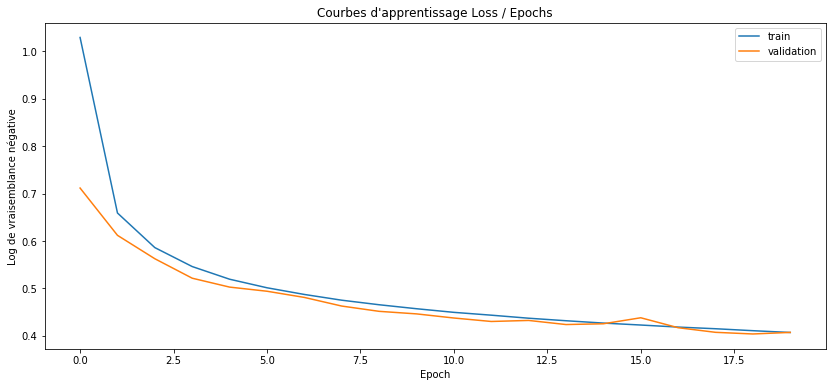

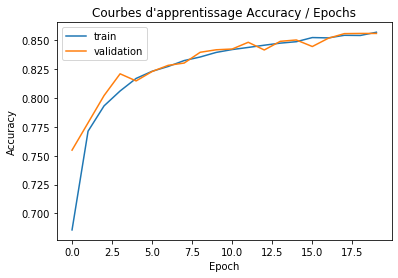

In [0]:
import time
from tensorflow import keras
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.datasets import fashion_mnist
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# import the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# shuffle the dataset
X_train, y_train = shuffle(X_train, y_train)

# pre-process: divide the "data" by 255 to shrink its size and keep it between [0-1]
X_train = X_train/255.0
X_test = X_test/255.0

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# split test data into test and validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# set up the DNN architecture
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(300, activation='relu', bias_initializer='ones' , use_bias=True))
model.add(Dense(300, activation='relu', bias_initializer='ones' , use_bias=True))
model.add(Dense(300, activation='relu', bias_initializer='ones' , use_bias=True))
model.add(Dense(10, activation='softmax', bias_initializer='ones' , use_bias=True))

# print the model summary
model.summary()

# set up parameters for the model
model.compile(optimizer=SGD(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# train the model, while collecting the loss calculated for each epoch
start_time = time.time()
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_validation, y_validation))
end_time = time.time()
# test the model and store the final loss and accuracy results
val_loss, val_acc = model.evaluate(X_validation, y_validation)
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

training_time_keras = end_time - start_time
print("Training Time = %.3f seconds" % (training_time_keras))

# collect and plot the losses for the training and validation sets
accuracies = history.history['acc']
losses = history.history['loss']
val_accuracies = history.history['val_acc']
val_losses = history.history['val_loss']

plt.figure(figsize=(14, 6))
plt.plot(losses, label="train")
plt.plot(val_losses, label="validation")
plt.title('Courbes d\'apprentissage Loss / Epochs')
plt.ylabel('Log de vraisemblance négative')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.figure()
plt.plot(accuracies, label="train")
plt.plot(val_accuracies, label="validation")
plt.title('Courbes d\'apprentissage Accuracy / Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.show()

## Comparison
For two models using the same of hyperparemters (number of hidden layers, nodes, learning rate) and both optimized with SGD, we have mainly 2 observations for running them 20 epochs each for a minibatch_size = 32:

*   The Keras implementation finishes the training faster in around 110 seconds, whereas the Numpy implementation finishes the training in around 284 seconds which is around the triple of the time taken by the high level framework Keras.
*   The Numpy implementation have surprisingly a better accuracy (92.29%) compared to Keras implementation (83.9%).

The curve below shows both of the models plotted together


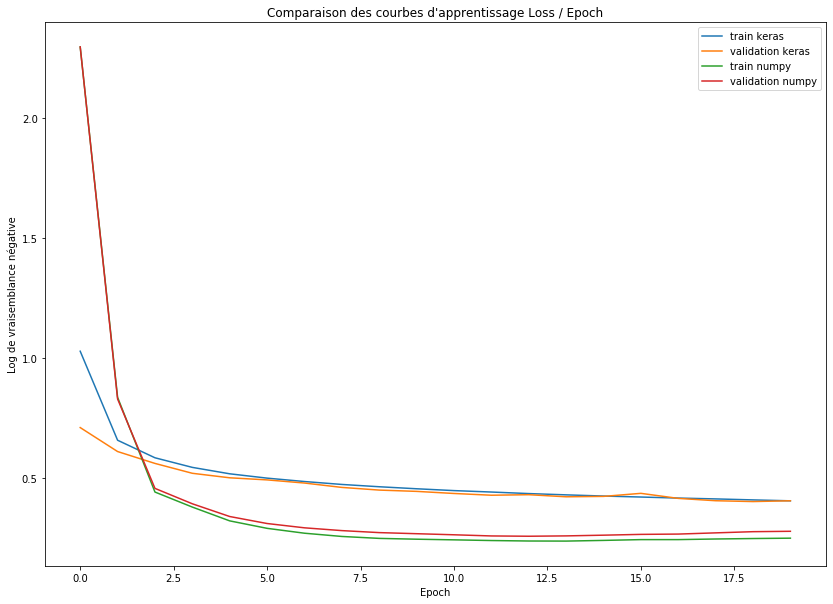

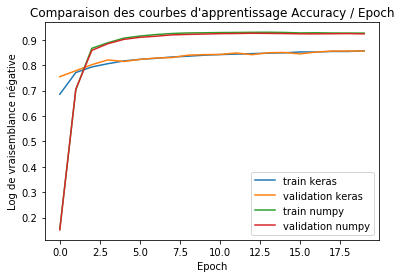

In [0]:
# collect and plot the losses for the training and validation sets

plt.figure(figsize=(14, 10))
plt.plot(losses, label="train keras")
plt.plot(val_losses, label="validation keras")
plt.plot(losses_train_numpy, label="train numpy")
plt.plot(losses_val_numpy, label="validation numpy")
plt.title('Comparaison des courbes d\'apprentissage Loss / Epoch')
plt.ylabel('Log de vraisemblance négative')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(accuracies, label="train keras")
plt.plot(val_accuracies, label="validation keras")
plt.plot(acc_numpy, label="train numpy")
plt.plot(acc_val_numpy, label="validation numpy")
plt.title('Comparaison des courbes d\'apprentissage Accuracy / Epoch')
plt.ylabel('Log de vraisemblance négative')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

__________________________

# 2. Part II

We have done experiments with 8 models, 7 of them are convolutional, and the last one is fully connected (which is different from the one implemented in the previous part of the TP).

__________________________________________________

Model_0
Validation loss: 0.28892692025899885
Validation accuracy: 0.8958


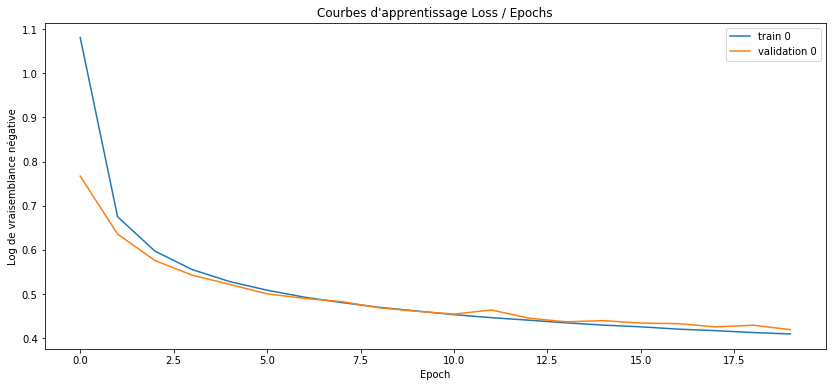

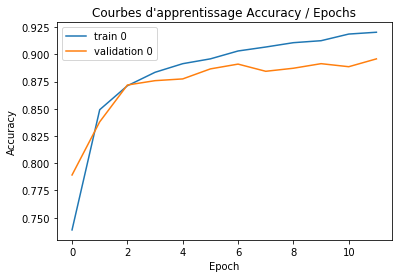

__________________________________________________

Model_1
Validation loss: 0.2884389573097229
Validation accuracy: 0.8886


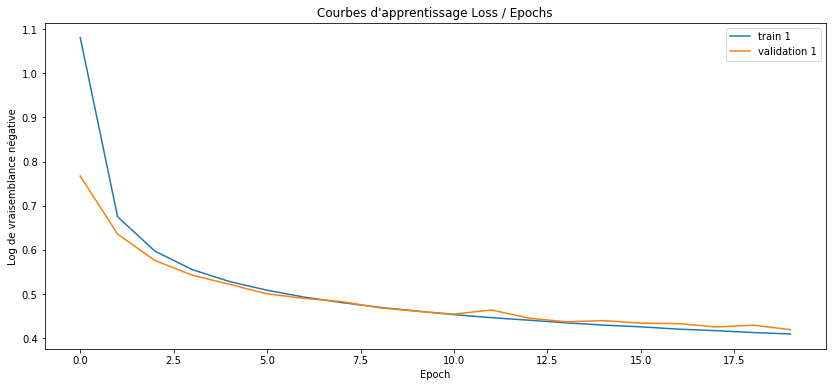

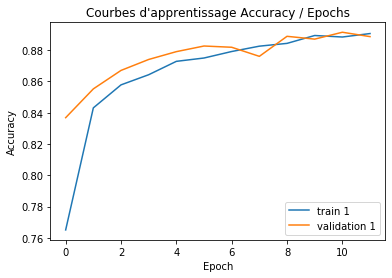

__________________________________________________

Model_2
Validation loss: 0.30390509974956514
Validation accuracy: 0.8852


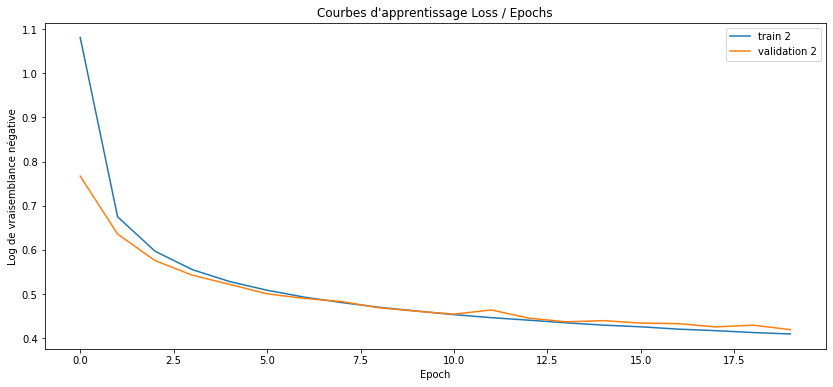

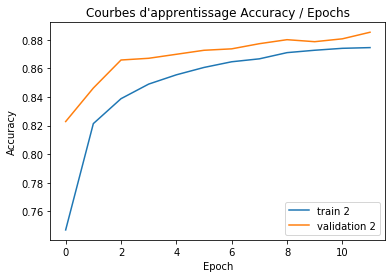

__________________________________________________

Model_3
Validation loss: 0.4214494156241417
Validation accuracy: 0.8436


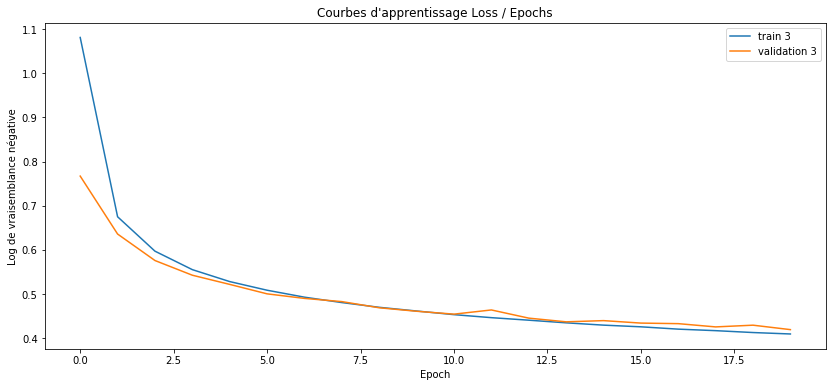

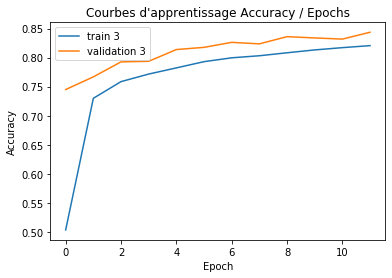

__________________________________________________

Model_4
Validation loss: 0.2821702230453491
Validation accuracy: 0.8922


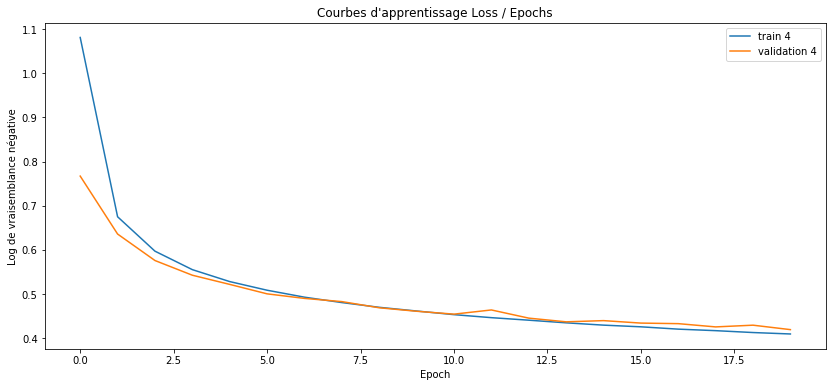

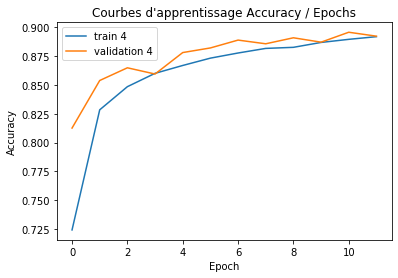

__________________________________________________

Model_5
Validation loss: 0.2651600144982338
Validation accuracy: 0.8994


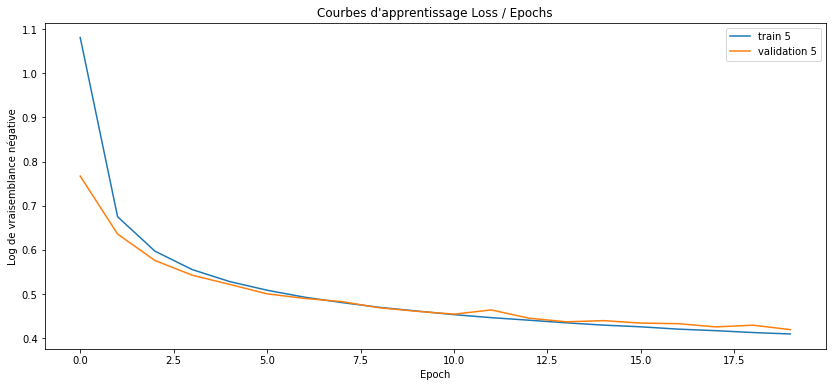

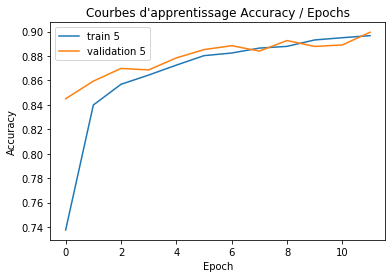

__________________________________________________

Model_6
Validation loss: 0.22133828665018082
Validation accuracy: 0.9202


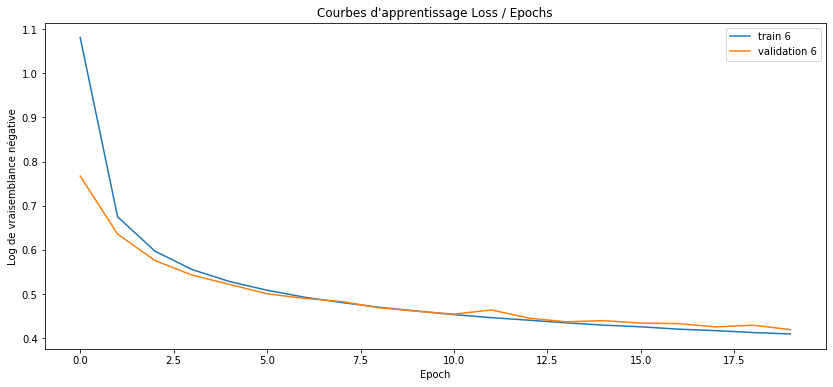

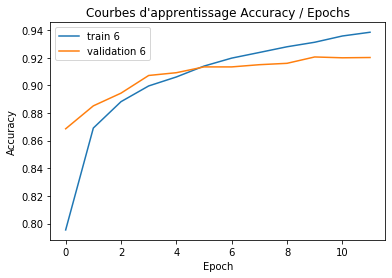

__________________________________________________

Model_7
Validation loss: 0.38728278210163114
Validation accuracy: 0.8566


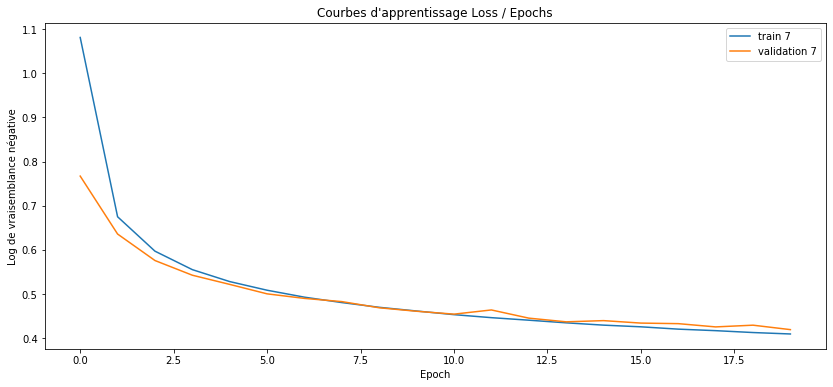

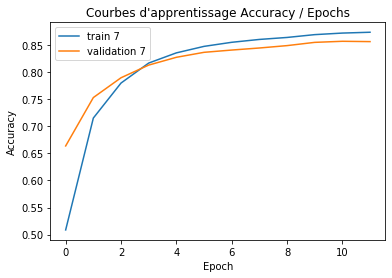

Best model is : model_6
Test loss: 0.2213500228524208
Test accuracy: 0.9296


In [0]:
import time
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adamax
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import backend as K

# import the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# shuffle the dataset
X_train, y_train = shuffle(X_train,y_train)

# reshape data to fit model
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

# pre-process: divide the "data" by 255 to shrink its size and keep it between [0-1]
X_train = X_train/255.0
X_test = X_test/255.0

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# split test data into test and validation
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# first model to compare
model_0 = Sequential()
model_0.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model_0.add(MaxPooling2D(pool_size=(4, 4)))
model_0.add(Conv2D(64, (3, 3), activation='relu'))
model_0.add(MaxPooling2D(pool_size=(2, 2)))
model_0.add(Flatten())
model_0.add(Dense(128, activation='relu'))
model_0.add(Dense(10, activation='softmax'))
model_0.compile(loss='categorical_crossentropy',optimizer=Adadelta(lr=1.0),metrics=['accuracy'])

# same as above but with less conv layers
model_1 = Sequential()
model_1.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model_1.add(MaxPooling2D(pool_size=(4, 4)))
model_1.add(Dropout(0.5))
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.25))
model_1.add(Dense(10, activation='softmax'))
model_1.compile(loss='categorical_crossentropy',optimizer=Adadelta(lr=1.0),metrics=['accuracy'])

# same as above but with less output channels for the conv layer
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model_2.add(MaxPooling2D(pool_size=(4, 4)))
model_2.add(Dropout(0.5))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(10, activation='softmax'))
model_2.compile(loss='categorical_crossentropy',optimizer=Adadelta(lr=1.0),metrics=['accuracy'])

# same as above but with different activation functions for the hidden layers
model_3 = Sequential()
model_3.add(Conv2D(32, kernel_size=(3, 3),
                 activation='sigmoid',
                 input_shape=(28,28,1)))
model_3.add(MaxPooling2D(pool_size=(4, 4)))
model_3.add(Dropout(0.5))
model_3.add(Flatten())
model_3.add(Dense(128, activation='sigmoid'))
model_3.add(Dropout(0.25))
model_3.add(Dense(10, activation='softmax'))
model_3.compile(loss='categorical_crossentropy',optimizer=Adadelta(lr=1.0),metrics=['accuracy'])

# same as model_2 but with more dense layers after conv
model_4 = Sequential()
model_4.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model_4.add(MaxPooling2D(pool_size=(4, 4)))
model_4.add(Dropout(0.5))
model_4.add(Flatten())
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(10, activation='softmax'))
model_4.compile(loss='categorical_crossentropy',optimizer=Adadelta(lr=1.0),metrics=['accuracy'])

# same as above but with more neurons in the dense layers
model_5 = Sequential()
model_5.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model_5.add(MaxPooling2D(pool_size=(4, 4)))
model_5.add(Dropout(0.5))
model_5.add(Flatten())
model_5.add(Dense(256, activation='relu'))
model_5.add(Dense(256, activation='relu'))
model_5.add(Dense(256, activation='relu'))
model_5.add(Dropout(0.25))
model_5.add(Dense(10, activation='softmax'))
model_5.compile(loss='categorical_crossentropy',optimizer=Adadelta(lr=1.0),metrics=['accuracy'])

# CNN Example from Keras Documentation
model_6 = Sequential()
model_6.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model_6.add(Conv2D(64, (3, 3), activation='relu'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))
model_6.add(Dropout(0.25))
model_6.add(Flatten())
model_6.add(Dense(128, activation='relu'))
model_6.add(Dropout(0.5))
model_6.add(Dense(10, activation='softmax'))

model_6.compile(loss='categorical_crossentropy',optimizer=Adadelta(),metrics=['accuracy'])


# Fully Connected Model
model_7 = Sequential()
model_7.add(Flatten(input_shape=(28,28,1)))
model_7.add(Dense(100, activation='sigmoid', bias_initializer='ones' , use_bias=True))
model_7.add(Dense(100, activation='sigmoid', bias_initializer='ones' , use_bias=True))
model_7.add(Dense(100, activation='sigmoid', bias_initializer='ones' , use_bias=True))
model_7.add(Dense(10, activation='softmax', bias_initializer='ones' , use_bias=True))
model_7.compile(loss='categorical_crossentropy',optimizer=Adamax(lr=0.001),metrics=['accuracy'])


models = [model_0, model_1, model_2, model_3, model_4, model_5, model_6, model_7]

best_validation = 0
best_model = -1
for i in range(len(models)):
    print("_"*50)
    print ("\nModel_%d" % (i))
    model = models[i]
    
    history = model.fit(X_train, y_train,
              batch_size=128,
              epochs=12,
              verbose=0, # silent mode to reduce the amount of prints in the report
              validation_data=(X_validation, y_validation))
    score = model.evaluate(X_validation, y_validation, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    if score[1] > best_validation:
      best_validation = score[1]
      best_model = i

    # collect and plot the losses for the training and validation sets
    accuracy = history.history['acc']
    loss = history.history[ 'loss']
    val_accuracy = history.history['val_acc']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(14, 6))
    plt.plot(losses_train, label="train {}".format(i))
    plt.plot(losses_val, label="validation {}".format(i))
    plt.title('Courbes d\'apprentissage Loss / Epochs')
    plt.ylabel('Log de vraisemblance négative')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

    plt.figure()
    plt.plot(accuracy, label="train {}".format(i))
    plt.plot(val_accuracy, label="validation {}".format(i))
    plt.title('Courbes d\'apprentissage Accuracy / Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

print("Best model is : model_%d" % (best_model))
score = models[best_model].evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])